/*
 * CNN Sequence classify for Sequence feature
 * Copyright (c) 2018-2019 Wei Zhou, ChaoRui Liu, All Rights Reserved.
 *
 * Permission is hereby granted, free of charge, to any person
 * obtaining a copy of this software and associated documentation
 * files (the "Software"), to deal in the Software without
 * restriction, including without limitation the rights to use,
 * copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the
 * Software is furnished to do so, subject to the following
 * conditions:
 *
 * The above copyright notice and this permission notice shall be
 * included in all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
 * EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
 * OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
 * NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
 * HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY,
 * WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
 * FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR
 * OTHER DEALINGS IN THE SOFTWARE.
 */

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime
import math
import time
import h5py
import random

In [2]:
with h5py.File('localtion_seq_dataset.h5','r') as h5r:
    labeled_data = h5r['labeled'].value
    labeled_class = h5r['classes'].value
    labeled_data = labeled_data.reshape(len(labeled_data),20,4,1)
input_x = tf.placeholder(tf.float32, shape=(None, 20, 4))
output_y = tf.placeholder(tf.float32, shape=(None,3))
input_x = tf.reshape(input_x,[-1,20,4,1])
print input_x.get_shape()

(?, 20, 4, 1)


In [3]:
def conv_op(input_op, name, kh, kw, n_out, dh, dw, p):  
    n_in = input_op.get_shape()[-1].value  
  
    with tf.name_scope(name) as scope:  
        kernel = tf.get_variable(scope + "w", 
                                 shape=[kh, kw, n_in, n_out],  
                                 dtype=tf.float32,  
                                 initializer=tf.contrib.layers.xavier_initializer_conv2d())  
        conv = tf.nn.conv2d(input_op, kernel, (1, dh, dw, 1), padding='VALID')  
        biases = tf.Variable(tf.constant(0.0, shape=[n_out], dtype=tf.float32), trainable=True, name='b')  
        z = tf.nn.bias_add(conv, biases)  
        activation = tf.nn.relu(z, name=scope)  
        p += [kernel, biases]  
        return activation  

In [4]:
def fc_op(input_op, name, n_out, p):
    n_in = input_op.get_shape()[-1].value
    with tf.name_scope(name) as scope:
        kernel = tf.get_variable(scope+"w",
                                shape = [n_in,n_out],
                                dtype = tf.float32,
                                initializer = tf.contrib.layers.xavier_initializer())
        biases = tf.Variable(tf.constant(0.1, shape=[n_out], dtype=tf.float32), name='b')
        activation = tf.nn.relu_layer(input_op, kernel, biases, name=scope)
        p += [kernel, biases]
        return activation

In [5]:
def mpool_op(input_op, name, kh, kw, dh, dw):
    return tf.nn.max_pool(input_op,
                         ksize=[1, kh, kw, 1],
                         strides=[1, dh, dw, 1],
                         padding='SAME',
                         name=name)

In [6]:
p = []
conv1_1 = conv_op(input_x, name="conv1_1", kh=1, kw=1, n_out=64, dh=1, dw=1, p=p)
conv1_2 = conv_op(conv1_1, name="conv1_2", kh=3, kw=4, n_out=64, dh=1, dw=1,p=p)
pool1 = mpool_op(conv1_2, name="pool1", kh=1, kw=2,dh=2,dw=1)#output 9x1x64
print pool1.get_shape()

(?, 9, 1, 64)


In [7]:
conv2_1 = conv_op(pool1, name="conv2_1", kh=2, kw=1, n_out=128, dh=1, dw=1, p=p)#output 8x1x128
conv2_2 = conv_op(conv2_1, name="conv2_2", kh=3, kw=1, n_out=128, dh=1,dw=1, p=p)#output 6x1x128
pool2 = mpool_op(conv2_2, name="pool2", kh=1, kw=2, dh=2, dw=1)#output 3x1x128
print pool2.get_shape()

(?, 3, 1, 128)


In [8]:
conv3_1 = conv_op(pool2, name="conv3_1", kh=1, kw=1, n_out=256, dh=1, dw=1, p=p)
print conv3_1.get_shape()

(?, 3, 1, 256)


In [9]:
keep_prob = tf.placeholder(tf.float32)

In [10]:
shp = conv3_1.get_shape()
fc_shape = shp[1].value*shp[2].value*shp[3].value
conv_reshap = tf.reshape(conv3_1,[-1,fc_shape],name="conv_reshap")
fc1 = fc_op(conv_reshap, name="fc1",n_out=3, p=p)
fc1_drop = tf.nn.dropout(fc1, keep_prob, name="fc1_drop")
y_out = tf.nn.softmax(fc1)

In [14]:
print y_out.get_shape()

(?, 3)


In [11]:
cross_entropy = -tf.reduce_sum(output_y*tf.log(y_out))
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(output_y,1),tf.argmax(y_out,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
print output_y.get_shape(),y_out.get_shape()

(?, 3) (?, 3)


In [12]:
data_index = []
for i in range(len(labeled_data)):
    data_index.append(i)

In [13]:
print len(data_index)

5567


In [14]:
vild_index = random.sample(data_index,1000)
vild_seq, vild_class = labeled_data[vild_index[:]], labeled_class[vild_index[:]]
print vild_class

[[0 0 1]
 [0 0 1]
 [0 0 1]
 ..., 
 [0 0 1]
 [1 0 0]
 [1 0 0]]


In [15]:
train_index = []
for i in range(len(data_index)):
    if data_index[i] in vild_index:
        print i
    else:
        train_index.append(data_index[i])

0
1
3
14
30
31
39
43
49
52
54
59
65
67
78
80
81
84
86
93
103
107
117
119
123
130
133
137
139
141
146
152
156
165
169
175
178
184
185
199
202
209
212
216
217
251
259
264
275
279
304
321
322
330
331
335
336
338
342
345
351
352
353
356
364
365
370
377
381
385
387
389
392
397
400
401
403
407
410
428
438
443
462
467
468
482
483
492
500
502
507
510
521
525
526
538
548
552
553
563
574
582
584
585
592
616
623
625
629
631
633
651
652
671
673
676
677
684
687
692
697
700
701
703
709
713
714
715
723
726
727
729
731
733
735
738
742
743
744
750
753
757
759
767
772
781
782
786
802
804
807
813
816
817
818
823
825
828
833
849
850
852
862
864
865
866
881
885
891
895
904
908
915
916
919
926
927
928
935
938
943
948
961
970
973
981
985
994
996
1002
1007
1009
1013
1023
1028
1029
1036
1042
1045
1049
1057
1070
1072
1077
1082
1086
1094
1099
1103
1107
1110
1111
1112
1121
1129
1138
1142
1143
1157
1160
1163
1164
1170
1177
1180
1182
1183
1185
1190
1196
1201
1205
1213
1214
1225
1226
1231
1238
1248
1266
1271
1281
12

In [16]:
print len(train_index)

4567


In [17]:
init = tf.global_variables_initializer()
print "===  Starting Session ==="
sess = tf.Session()
sess.run(init)
print "Initial Accuracy", sess.run(accuracy, feed_dict={input_x:vild_seq, output_y:vild_class,keep_prob:1.})

===  Starting Session ===
Initial Accuracy 0.329


In [18]:
vild = []
enpoch_number = 5000
for i in range(enpoch_number):
    data_slice = random.sample(train_index,50)
    sess.run(train_step,feed_dict={input_x:labeled_data[data_slice[:]], output_y:labeled_class[data_slice[:]],keep_prob:0.5})
    vild_cc = sess.run(accuracy, feed_dict={input_x:vild_seq, output_y:vild_class,keep_prob:0.5})
    print vild_cc
    vild.append(vild_cc)

0.414
0.415
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.414
0.415
0.41
0.358
0.352
0.355
0.372
0.415
0.415
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.418
0.406
0.383
0.372
0.373
0.358
0.355
0.36
0.354
0.35
0.347
0.353
0.358
0.358
0.365
0.348
0.369
0.375
0.378
0.392
0.401
0.405
0.411
0.415
0.412
0.415
0.412
0.414
0.415
0.415
0.415
0.415
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.417
0.417
0.417
0.416
0.416
0.416
0.416
0.416
0.418
0.415
0.411
0.412
0.412
0.417
0.417
0.417
0.417
0.417
0.419
0.416
0.415
0.415
0.388
0.367
0.357
0.36
0.368
0.373
0.367
0.364
0.374
0.395
0.408
0.417
0.422
0.417
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.416
0.418
0.416
0.42
0.414
0.428
0.401
0.397
0.4
0.384
0.375
0.379
0.378
0.375
0.378
0.397
0.403
0.42
0.42
0.415
0.414
0.415
0.412
0.416
0.414
0.414
0.41
0.413
0.415
0.417
0.413
0.42
0.417
0.417
0.418
0.418
0.416
0.419
0.418
0.416
0.418
0.416
0.4

In [22]:
x = []
for i in range(5000):
    x.append(i)

In [20]:
import matplotlib.pyplot as plt

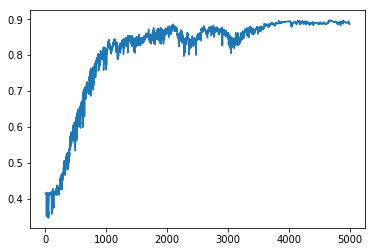

In [24]:
plt.plot(x,vild)
plt.show()

In [26]:
saver = tf.train.Saver()

In [27]:
saver.save(sess,'loc_model/model.ckpt',enpoch_number)

'loc_model/model.ckpt-5000'